In [2]:
import claudio
import librosa
import numpy as np
import os
import pandas
import time
import hcnn.common.config as C
import hcnn.driver
import hcnn.common.utils as utils
import hcnn.train.streams
import hcnn.data.cqt

%matplotlib inline
import seaborn
# import mpld3

seaborn.set()
np.set_printoptions(precision=4, suppress=True)
# mpld3.enable_notebook()

config = C.Config.load("./data/integration_config.yaml")

In [3]:
partitions = None  # ['rwc', 'uiowa', 'philharmonia']
feature_mode = 'cqt'  # ['cqt', 'wcqt', 'hcqt']
t0 = time.time()
driver = hcnn.driver.Driver(config, partitions=partitions, feature_mode=feature_mode,
                            load_features=True)
t_end = time.time()
print("Took", t_end - t0, "seconds to load")
print("Total # Samples:", len(driver.dataset))
sample_df = driver.dataset.to_df()
assert not sample_df.empty

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0061s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:    0.0s finished
Took 0.5953400135040283 seconds to load
Total # Samples: 360


In [67]:
import matplotlib.pyplot as plt
def viz_audio(record, downsample_rate=150):
    """Plot the audio from a record"""
    audio_path = record["audio_file"][0]
    audio, sr = claudio.read(audio_path, channels=1)
    print("N samples: {}\nDuration: {:.3f}s\nsr: {}".format(audio.shape[0], len(audio)/sr, sr))
    
    plt.figure(figsize=(6, 2))
    print(audio.shape)
    plt.plot(audio[::downsample_rate])
    

def play_audio(record):
    """Play the audio from a record"""
    import claudio.sound
    audio, sr = claudio.read(path, channels=1)
    claudio.sound.soundsc(audio, sr)

    
def viz_features(record):
    """Vizualize the features from a record."""
    import librosa.display
    cqt_path = record.cqt
    cqt_feats = np.load(cqt_path)['cqt']
    cqt = cqt_feats.reshape((cqt_feats.shape[1], cqt_feats.shape[2]))
    print("CQT Shape:", cqt.shape)
    
    
    plt.figure(figsize=(8, 4))
    librosa.display.specshow(cqt.T, x_axis='time', y_axis="cqt_hz",
                                 fmin=hcnn.data.cqt.CQT_PARAMS['fmin'], fmax=10000,
                                 bins_per_octave=hcnn.data.cqt.CQT_PARAMS['bins_per_octave'])
#     plt.imshow(np.log(cqt.T), aspect="auto", interpolation="none", cmap="OrRd", origin='lower')
#     plt.colorbar(format='%+2.0f dB')
#     plt.title('Constant-Q power spectrogram (Hz)')
    

def viz_slicer(slicer, mode='cqt'):
    """Vizualize the features from a record."""
    import librosa.display
    data = next(slicer)
        
    plt.figure(figsize=(8, 4))
    if mode == 'cqt':
        features = data['x_in'][0, 0, ::]
#         plt.imshow(features.T, aspect="auto", interpolation="none", cmap="OrRd", origin='lower')
        
        librosa.display.specshow(features.T, x_axis='time', y_axis="cqt_hz",
                                 fmin=hcnn.data.cqt.CQT_PARAMS['fmin'], fmax=8000,
                                 bins_per_octave=hcnn.data.cqt.CQT_PARAMS['bins_per_octave'])
        plt.colorbar(format='%+2.0f dB')
        plt.title('Constant-Q power spectrogram (Hz); instrument={}'.format(data['target']))


Path: Guitar.pp.sulD.D3B3.mono_9.flac from uiowa instrument: guitar
CQT Shape: (167, 204)


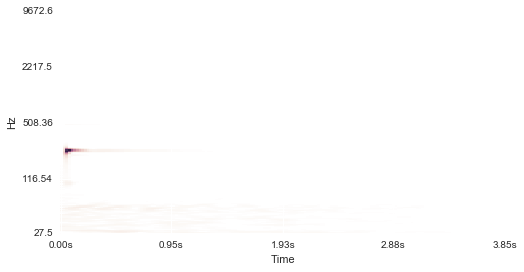

In [75]:
sample = sample_df.sample().iloc[0]
# print(sample)

path = sample.audio_file
dataset = sample.dataset
instrument = sample.instrument
assert 'cqt' in sample
print("Path:", os.path.basename(path), "from", dataset, "instrument:", instrument)

# # viz_audio(sample)
viz_features(sample)

# play_audio(sample)

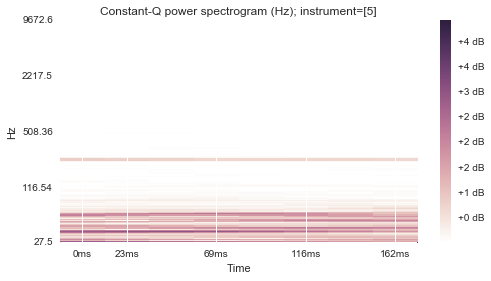

In [81]:
t_len = 8
cqt_slicer = hcnn.train.streams.cqt_slices(sample, t_len)
wcqt_slicer = hcnn.train.streams.wcqt_slices(sample, t_len)
hcqt_slicer = hcnn.train.streams.hcqt_slices(sample, t_len)

# print(next(cqt_slicer))
# # viz_audio(sample)
viz_slicer(cqt_slicer, mode='cqt')